# Diffusion with boundary condition on the MNIST 

This notebook aims to demonstrate that tangent diffusion with boundary conditions
on the observed layer yields a generative model. 

## 1 - Load the MNIST dataset

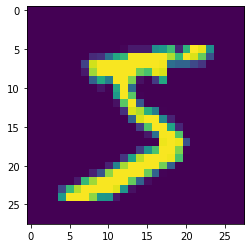

In [2]:
from torchvision.datasets import MNIST
import torch
import matplotlib.pyplot as plt
from PIL import Image

mnist = MNIST("../datasets")
x, y  = mnist[0]
plt.imshow(x)
x

## 2 - Define a layered system of binary variables

We first define a small function to return index pairs between convolutional layers.

In [3]:
from itertools import product

# Convolutional layer connections 

def convlayer(sizeX, sizeY=None, radius=1):
    sizeY = sizeY if sizeY else sizeX
    edges = []
    k = sizeX / sizeY
    r = radius if radius else k
    def ball(x, bound):
        return range(int(max(x - r, 0)), int(min(x + r + 1, bound)))
    for i in range(sizeY ** 2):
        y0, y1 = divmod(i, sizeY)
        edges += [[i, a * sizeX + b] for a in ball(k * y0, sizeX)\
                                     for b in ball(k * y1, sizeX)]
    return edges

Next we can map layer sizes to a set of Domain keys like so:

In [4]:
from topos import System

# Vertices (atoms - neurons)
sizes  = {'x' : 28, 
          'y' : 14, 
          'z' : 9}

layers = {k: [f"{k}{i}" for i in range(n**2)]\
             for k, n in sizes.items()}

nodes = [n for lk in layers.values() for n in lk]


# Edges (interactions - synapses)
rs = {('x', 'y') : 1, 
      ('y', 'z') : 2}

convs = {k: convlayer(sizes[k[0]], sizes[k[1]], r)\
            for k, r in rs.items()}


edges = [f"{k[0]}{i}:{k[1]}{j}" for k, es in convs.items()\
                                for i, j in es]

In [5]:
"""System creation: may take some time! """
print("> Computing system operators...")
K = System(nodes + edges, degree=1)
print(f"rank\t: {K.rank}")
print(f"sizes\t: {[Ki.size for Ki in K.grades]}")

> Computing system operators...
rank	: 1
sizes	: [15570, 9054]


## 3 - Consistent beliefs 

The state of our network is a collection of beliefs $(p_\alpha) \in A^*_0(K)$ where $p_\alpha$ is a joint probability density on the microstate of atoms inside $\alpha$ for every $\alpha \in K$.

Belief propagation is a non-linear algorithm attempting to project $p$ on the submanifold $\Gamma(K)$ of 
__consistent__ beliefs, defined by the equations:

$$ p_\beta(x_\beta) = \sum_{y \in E_{\alpha \setminus \beta}} p_\alpha(x_\beta, y) \qquad
\mathrm{for\;all} \; \beta \subseteq \alpha \; \mathrm{in} \; K$$

This version of BP, described in [[1]](#references), makes use of a time step $dt \leq 1$ to regularise diffusion, acting as exponent of messages. A multiplicative Möbius inversion has also been applied to messages. 

In [6]:
# zeta-conjugate of the divergence, acting on local hamiltonians U.
div  = K.zeta[0] @ K.delta[1] @ K.mu[1]

In [7]:
def BP(p, dt=0.8, nit=20):
    U = K._ln(p)
    dt_div = dt * div
    for i in range(nit):
        U -= div(K.Deff(U))
        U -= K.freenrj(U)
    p1 = K.gibbs(U)
    return p1

In [8]:
print("> Initialising from normally sampled potentials u")
p = K.gibbs(0.1 * K[0].randn())
print(f"p = {K.gibbs}({K.zeta} u)\n")

print("> BP")
print(f"d(p0).norm() == {K.d(p).norm():.0e}")
p = BP(p)
print(f"\nd(p1).norm() == {K.d(p).norm():.0e}")

> Initialising from normally sampled potentials u
p = (e- / Σ e-)(ζ u)

> BP
d(p0).norm() == 4e+00

d(p1).norm() == 3e-06


# 3 - Tangent diffusion with boundary conditions

Every image defines a collection of local magnetizations $q_i \in {\rm Prob}(\{ \pm 1 \})$ for $i \in K_{in}$. Batches of images also define local magnetizations $q_i$ by convex combination. To $q$ we associate the boundary observable $V_{x}$: 

$$ V_{x:i}(\sigma_i) = \frac {q_i(\sigma_i)} {p_i(\sigma_i)} \qquad {\rm for}\; i \in K_{x}$$


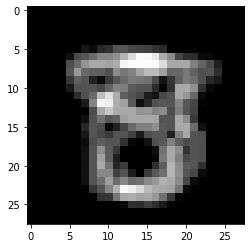

In [85]:
def observe(size, out=2):
    js = torch.randint(len(mnist), [size])
    qs = torch.stack([mnist.data[j] for j in js])
    q = qs.sum(dim=[0]).float() / size
    q = (1 + q) / 257
    if out == 2:
        return torch.stack([q, 1 - q]).transpose(0, -1)
    elif out == -1: 
        return 1 - q
    else:
        return q
    
q = observe(3, out=1)
im = Image.fromarray((255 * q).numpy())
plt.imshow(im)

In [10]:
# Restriction and embedding on input layer
Res_X  = K[0].res(layers['x'])
J_X    = Res_X.t()
X      = Res_X.tgt

# Projectors on X and K_int = K - X.
P_X    = J_X @ Res_X
P_int  = K[0].id - P_X  

div_int = K.zeta[0] @ (P_int @ K.delta[1]) @ K.mu[1]

def TangentDiffusion(p, V, nit=6, dt=0.8, P_int=P_int, nabla=None):  
    
    #--- Compute tangent operators ---
    if nabla == None:
        nabla = K.nabla(p, 0)[0]       # Conditional energy gradients
    div_int = K.zeta[0]\
            @ (P_int @ K.delta[1])\
            @ K.mu[1]                # Divergence with boundary condition
    
    ones = K.ones(0)
    pV   = K.ones(0)
    flow = dt * div_int @ nabla 
    
    #--- Run ---
    for i in range(nit):
        V -= flow(V) 
        V -= K.sums(p * V)
        V += ones
    return V

Then run diffusion on local evidence:

In [11]:
qx = X.field(observe(10, out=2), degree=0)
px = Res_X(p)
Vx = K.zeta @ J_X(qx / px)

print(f"> Tangent BP:")
print(f"\u2207(V0).norm() = {K.nabla(p, 0)(Vx).norm():.0e}", end="\n")
V  = TangentDiffusion(p, Vx, nit=20)
print(f"\u2207(V1).norm() = {K.nabla(p, 0)(V).norm():.0e}", end="\n")

> Tangent BP:
∇(V0).norm() = 3e+01
∇(V1).norm() = 1e-04


## 4 - Updating beliefs from experience

From every new evidence we obtain energies $V$ tangent to the consistent manifold by linearised diffusion. 
These energies approximate conditional probabilities with respect to the state of the boundary:

$$ V(\sigma_\alpha) \simeq  p_\alpha(\sigma_\alpha \,|\, \sigma_{X}) $$

This allows to update beliefs by $p' = p _\cdot {\rm e}^{\theta V}$ for $\theta \in \mathbb{R+}$, to increase the probability of inner states compatible with the observed states on the boundary.

In [14]:
theta = 0.05
p1 = p * K.exp_(- theta * V)
p1 = K.normalise(p1)
print(f"V.norm():\t {V.norm():.2e}")
print(f"d(p).norm():\t {K.d(p1).norm():.2e}")

V.norm():	 2.92e+02
d(p).norm():	 2.10e-03


Est-ce que si $dU = 0$ alors $u_\alpha = \mu(U)_\alpha$ est dans $S_\alpha$ pour tout $\alpha$? 

In [15]:
p1 = BP(p1, nit=12, dt=0.8)
print(f"d(p).norm():\t {K.d(p1).norm():.2e}")

d(p).norm():	 3.26e-06


In [53]:
def train (p0, nit=5, dt=0.7, batch=6, theta=0.05):
    p = 1 * p0
    for i in range(nit):
        #--- Estimate conditional probabilities
        qx = X.field(observe(batch), 0)
        Vx = K.zeta[0] @ J_X(qx / Res_X(p))
        V  = TangentDiffusion(p, Vx, nit=20, dt=dt)
        #--- Update beliefs
        p *= K.exp_(- theta * V)
        p = K.normalise(p)
        p = BP(p, nit=12, dt=dt)
        print("::", end="")
    return p

In [54]:
ps = [p, p1]

In [63]:
ps += [train(ps[-1], 10, batch=1, dt=0.2, theta=0.05)]
print(f"\nd(p).norm(): {K.d(ps[-1]).norm():.2e}")

::::::::::::::::::::
d(p).norm(): 2.96e-06


## 5 - Generating images

In [78]:
# Restriction and embedding on the last layer
Res_Z  = K[0].res(layers['z'])
J_Z    = Res_Z.t()
Z      = Res_Z.tgt

# Projector on the first layers
P_XY = K[0].id - J_Z @ Res_Z

def sample(p, g=None, nit=20, dt=0.3, br=0.5):
    pz, px = Res_Z(p), Res_X(p)
    qz = Z.gibbs(Z._ln(pz) + br * Z.randn(0))
    Vz = K.zeta @ J_Z(qz / Res_Z(p))
    V = TangentDiffusion(p, Vz, nit=nit, P_int=P_XY, dt=dt)
    return px * Res_X(V)

def img(qx):
    bmp = qx.data[::2].reshape([28, 28]).t().numpy()
    return Image.fromarray(255 * bmp)

tensor(25.2374) tensor(25.2374)


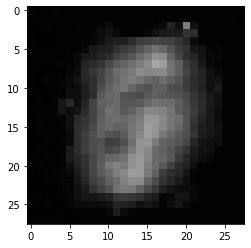

In [79]:
qx = sample(ps[-1], br=20)

print(qx.norm(), Res_X(ps[-1]).norm())

plt.imshow(img(qx), vmin=0, vmax=255)

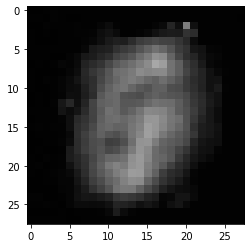

In [82]:
px = Res_X(ps[-1])
plt.imshow(img(px))